# Spatio-Temporal Rental Valuation Model - Complete Explanation

This notebook provides a **comprehensive, step-by-step explanation** of the rental valuation model used in JARZ-AI (RentRadar).

## What You'll Learn

1. **Theory**: Quantile regression, spatial features, temporal features, SHAP explainability
2. **Implementation**: How each function works and why it's designed that way
3. **Visualizations**: matplotlib plots showing data distributions, model predictions, and feature importance
4. **Mathematics**: The statistical and ML concepts behind the model

## Problem Statement

We want to predict **rental prices** for UK districts (like "NW1", "E14", "M1") with **uncertainty quantification**:
- **P10** (10th percentile): Pessimistic estimate
- **P50** (50th percentile/median): Best estimate  
- **P90** (90th percentile): Optimistic estimate

This gives us a prediction **interval** rather than a single point, which is crucial for real estate decisions.

## 1. Import Libraries and Setup

In [1]:
# Core data manipulation
import numpy as np
import pandas as pd
import pickle
from pathlib import Path
from typing import Dict, Tuple, Optional, Any

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.patches as mpatches

# Machine Learning
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import GradientBoostingRegressor
from scipy.spatial.distance import cdist

# Set visualization defaults
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Pandas display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

print("✅ Libraries loaded successfully!")

✅ Libraries loaded successfully!


## 2. Quantile Regression Theory

### What is Quantile Regression?

**Ordinary Least Squares (OLS) Regression** predicts the **mean** (average) value:

$$
\min_{\beta} \sum_{i=1}^n (y_i - x_i^T\beta)^2
$$

**Quantile Regression** predicts a specific **quantile** (percentile):

$$
\min_{\beta} \sum_{i=1}^n \rho_\tau(y_i - x_i^T\beta)
$$

where the **quantile loss function** is:

$$
\rho_\tau(u) = \begin{cases}
\tau \cdot u & \text{if } u \geq 0 \\
(\tau - 1) \cdot u & \text{if } u < 0
\end{cases}
$$

### Why Use Quantile Regression?

1. **Uncertainty Quantification**: Get prediction intervals (P10-P90) instead of single point estimates
2. **Robustness**: Less affected by outliers than OLS
3. **Asymmetric Loss**: Different penalties for over/under-prediction
4. **Risk Management**: Know the range of possible outcomes

### Visual Comparison

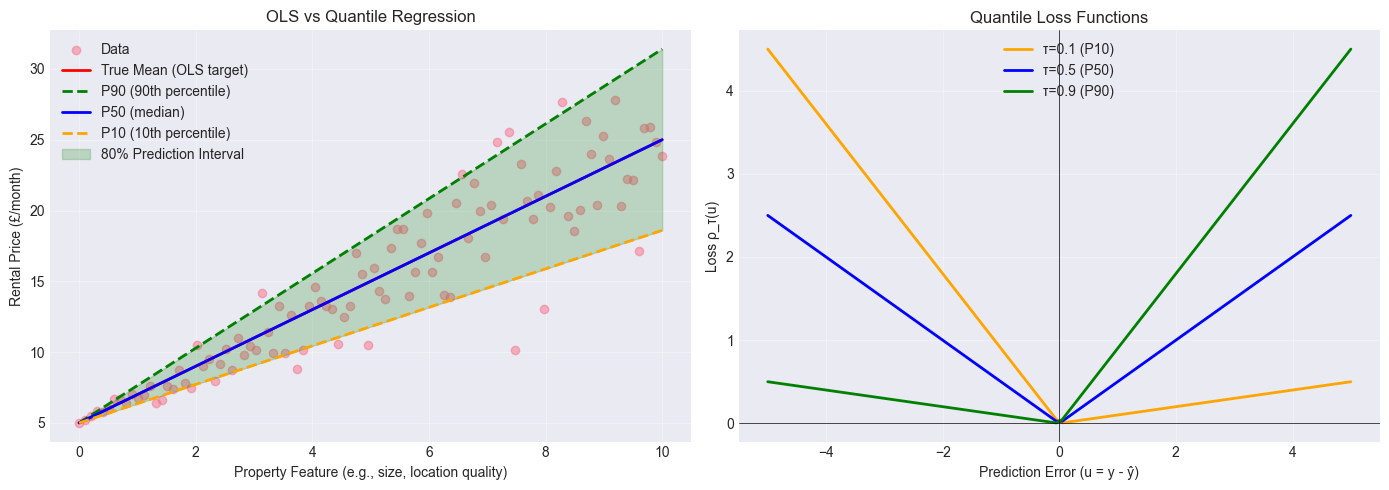

📊 Key Insight: Quantile regression fits different 'lines' through the data to capture
   the distribution at P10 (pessimistic), P50 (median), and P90 (optimistic).


In [2]:
# Generate synthetic data to illustrate quantile regression
np.random.seed(42)
X_demo = np.linspace(0, 10, 100)
y_demo = 2 * X_demo + 5 + np.random.normal(0, X_demo * 0.5, 100)  # Heteroscedastic noise

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left plot: OLS vs Quantile Regression
axes[0].scatter(X_demo, y_demo, alpha=0.5, label='Data')
axes[0].plot(X_demo, 2 * X_demo + 5, 'r-', linewidth=2, label='True Mean (OLS target)')
axes[0].plot(X_demo, 2 * X_demo + 5 + 1.28 * X_demo * 0.5, 'g--', linewidth=2, label='P90 (90th percentile)')
axes[0].plot(X_demo, 2 * X_demo + 5, 'b-', linewidth=2, label='P50 (median)')
axes[0].plot(X_demo, 2 * X_demo + 5 - 1.28 * X_demo * 0.5, 'orange', linestyle='--', linewidth=2, label='P10 (10th percentile)')
axes[0].fill_between(X_demo, 2 * X_demo + 5 - 1.28 * X_demo * 0.5, 2 * X_demo + 5 + 1.28 * X_demo * 0.5, alpha=0.2, color='green', label='80% Prediction Interval')
axes[0].set_xlabel('Property Feature (e.g., size, location quality)')
axes[0].set_ylabel('Rental Price (£/month)')
axes[0].set_title('OLS vs Quantile Regression')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: Quantile Loss Function
u = np.linspace(-5, 5, 100)
tau_values = [0.1, 0.5, 0.9]
colors = ['orange', 'blue', 'green']

for tau, color in zip(tau_values, colors):
    rho = np.where(u >= 0, tau * u, (tau - 1) * u)
    axes[1].plot(u, rho, label=f'τ={tau} (P{int(tau*100)})', linewidth=2, color=color)

axes[1].set_xlabel('Prediction Error (u = y - ŷ)')
axes[1].set_ylabel('Loss ρ_τ(u)')
axes[1].set_title('Quantile Loss Functions')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].axvline(0, color='black', linewidth=0.5)

plt.tight_layout()
plt.show()

print("📊 Key Insight: Quantile regression fits different 'lines' through the data to capture")
print("   the distribution at P10 (pessimistic), P50 (median), and P90 (optimistic).")

## 3. Configuration and UK District Geography

The model uses hardcoded coordinates for UK districts to enable spatial feature engineering.

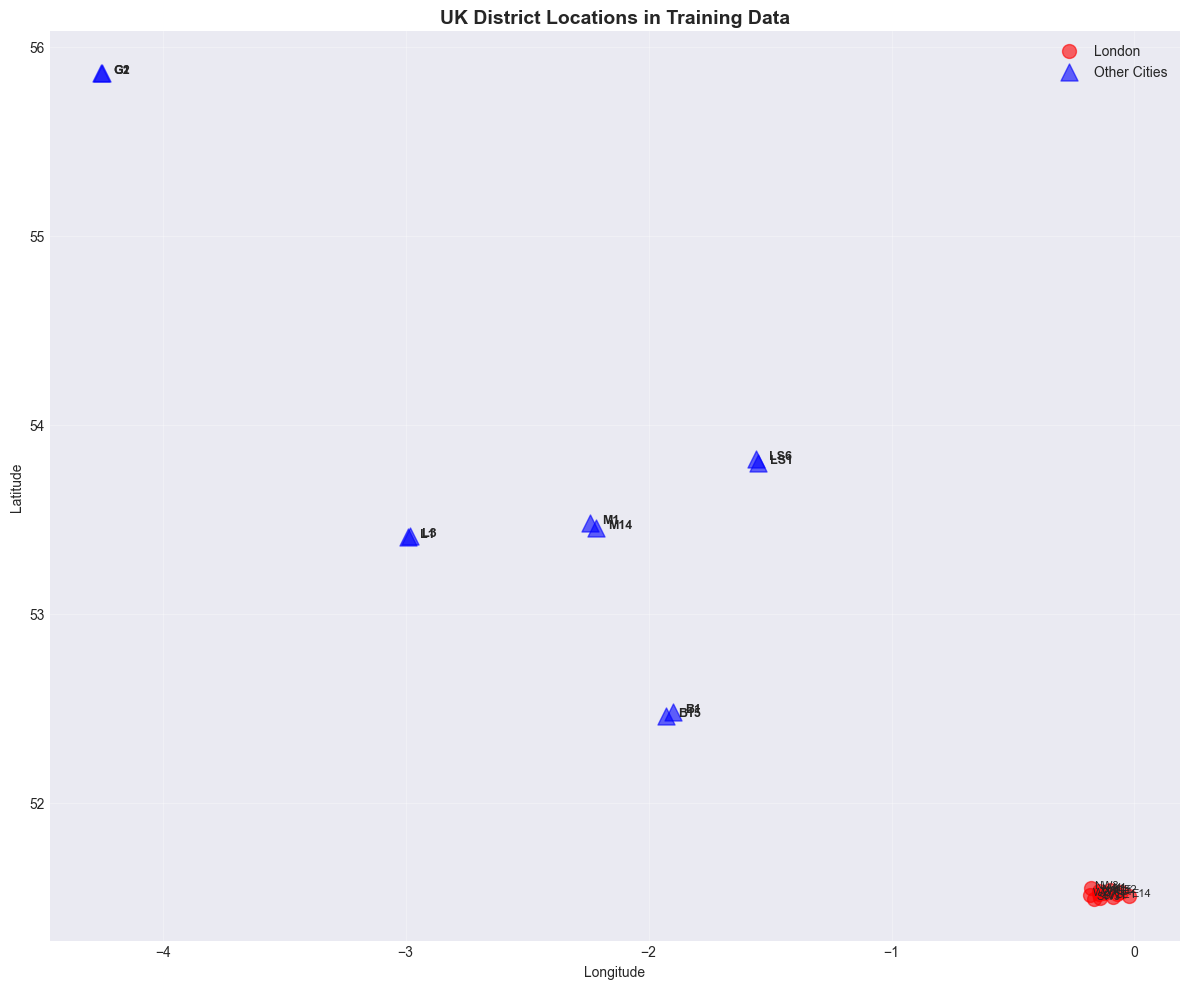

📍 Total districts with coordinates: 22
📊 Rental profiles defined: ['prime_london', 'central_london', 'outer_london', 'major_city', 'suburban']


In [3]:
# District coordinates from train_model.py
DISTRICT_COORDS = {
    # London areas
    "E1": (51.515, -0.073), "E2": (51.529, -0.056), "E14": (51.507, -0.024),
    "N1": (51.539, -0.102), "NW1": (51.534, -0.147), "NW3": (51.550, -0.177),
    "SE1": (51.501, -0.089), "SW1": (51.495, -0.141), "SW3": (51.489, -0.168),
    "W1": (51.515, -0.144), "W2": (51.514, -0.181), "WC1": (51.521, -0.123),
    # Major cities
    "M1": (53.481, -2.243), "M14": (53.453, -2.217),  # Manchester
    "B1": (52.480, -1.900), "B15": (52.461, -1.930),  # Birmingham
    "L1": (53.408, -2.992), "L3": (53.410, -2.981),   # Liverpool
    "LS1": (53.800, -1.549), "LS6": (53.820, -1.556), # Leeds
    "G1": (55.861, -4.251), "G2": (55.864, -4.253),   # Glasgow
}

# Rental profiles: different area types have different rental price distributions
RENTAL_PROFILES = {
    "prime_london": {"mean": 4500, "std": 1500, "min": 2000, "max": 15000},
    "central_london": {"mean": 2800, "std": 800, "min": 1500, "max": 6000},
    "outer_london": {"mean": 1800, "std": 500, "min": 1000, "max": 3500},
    "major_city": {"mean": 1200, "std": 400, "min": 600, "max": 2500},
    "suburban": {"mean": 1000, "std": 300, "min": 500, "max": 2000},
}

# Visualize UK districts on a map
fig, ax = plt.subplots(figsize=(12, 10))

# Group districts by city
london_districts = {k: v for k, v in DISTRICT_COORDS.items() if not k[0] in ['M', 'B', 'L', 'G'] and not k.startswith('LS')}
other_districts = {k: v for k, v in DISTRICT_COORDS.items() if k not in london_districts}

# Plot London districts
for district, (lat, lon) in london_districts.items():
    ax.scatter(lon, lat, s=100, alpha=0.6, c='red', label='London' if district == 'E1' else '')
    ax.text(lon + 0.01, lat, district, fontsize=8)

# Plot other major cities
for district, (lat, lon) in other_districts.items():
    ax.scatter(lon, lat, s=150, alpha=0.6, c='blue', marker='^', label='Other Cities' if district == 'M1' else '')
    ax.text(lon + 0.05, lat, district, fontsize=9, fontweight='bold')

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('UK District Locations in Training Data', fontsize=14, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📍 Total districts with coordinates: {len(DISTRICT_COORDS)}")
print(f"📊 Rental profiles defined: {list(RENTAL_PROFILES.keys())}")

## 4. Spatial Feature Engineering Theory

### Why Spatial Features Matter in Real Estate

**Tobler's First Law of Geography**: *"Everything is related to everything else, but near things are more related than distant things."*

In rental markets:
- Properties in wealthy neighborhoods tend to have higher rents
- Nearby districts share similar demographics, transport links, amenities
- **Spatial autocorrelation**: Rent in district A correlates with rent in nearby district B

### K-Nearest Neighbors (KNN) Spatial Features

For each district, we find its K nearest neighbors geographically and compute:

$$
\text{spatial\_rent\_neighbor\_avg} = \frac{1}{K} \sum_{i=1}^K \text{rent}_i
$$

### Distance Metric

We use **Euclidean distance** between (lat, lon) coordinates:

$$
d(A, B) = \sqrt{(\text{lat}_A - \text{lat}_B)^2 + (\text{lon}_A - \text{lon}_B)^2}
$$

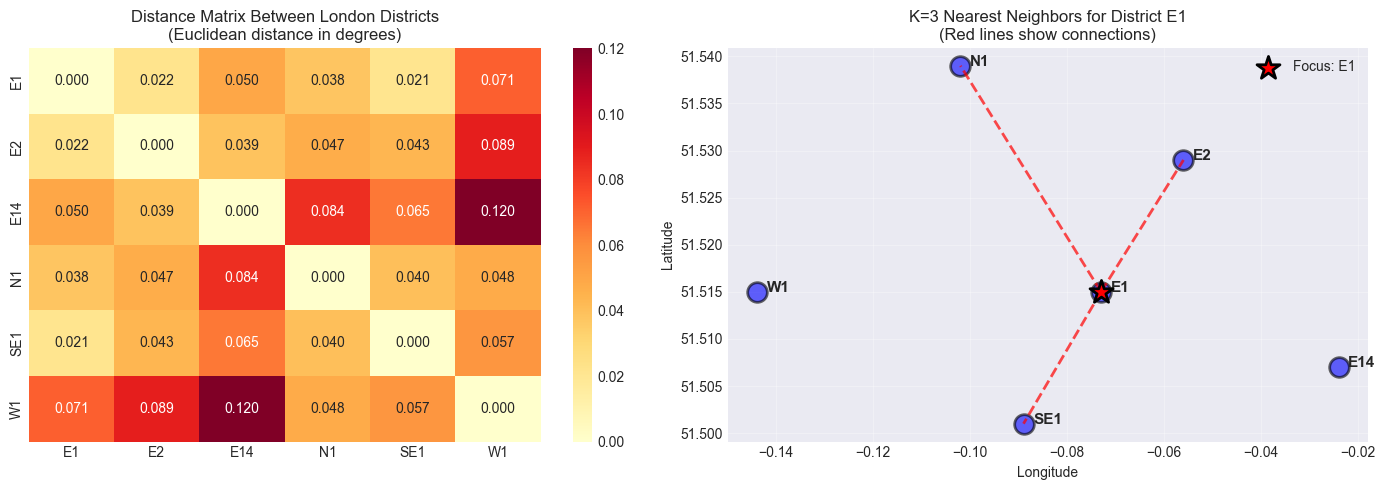

✅ E1's 3 nearest neighbors: ['SE1', 'E2', 'N1']
   Distances: ['0.0213', '0.0220', '0.0376']


In [4]:
# Demonstrate spatial feature engineering with London districts
london_sample = {"E1": (51.515, -0.073), "E2": (51.529, -0.056), "E14": (51.507, -0.024),
                 "N1": (51.539, -0.102), "SE1": (51.501, -0.089), "W1": (51.515, -0.144)}

districts = list(london_sample.keys())
coords = np.array(list(london_sample.values()))

# Compute distance matrix
dist_matrix = cdist(coords, coords, metric='euclidean')

# Visualize distance matrix as heatmap
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distance matrix heatmap
sns.heatmap(dist_matrix, xticklabels=districts, yticklabels=districts, annot=True, 
            fmt='.3f', cmap='YlOrRd', ax=axes[0])
axes[0].set_title('Distance Matrix Between London Districts\n(Euclidean distance in degrees)')

# K-nearest neighbors visualization (K=3)
K = 3
axes[1].scatter(coords[:, 1], coords[:, 0], s=200, c='blue', alpha=0.6, edgecolors='black', linewidths=2)
for i, district in enumerate(districts):
    axes[1].text(coords[i, 1] + 0.002, coords[i, 0], district, fontsize=11, fontweight='bold')

# Draw connections to K nearest neighbors for E1
focus_idx = 0  # E1
nearest_idx = np.argsort(dist_matrix[focus_idx])[1:K+1]  # Exclude self
for idx in nearest_idx:
    axes[1].plot([coords[focus_idx, 1], coords[idx, 1]], 
                [coords[focus_idx, 0], coords[idx, 0]], 
                'r--', alpha=0.7, linewidth=2)

axes[1].scatter(coords[focus_idx, 1], coords[focus_idx, 0], s=300, c='red', 
               marker='*', edgecolors='black', linewidths=2, label='Focus: E1', zorder=5)
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].set_title(f'K={K} Nearest Neighbors for District E1\n(Red lines show connections)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ E1's {K} nearest neighbors: {[districts[i] for i in nearest_idx]}")
print(f"   Distances: {[f'{dist_matrix[focus_idx, i]:.4f}' for i in nearest_idx]}")

## 5. Temporal Feature Engineering Theory

Time series features capture **market dynamics**:

### Key Temporal Features

1. **6-Month Growth Rate**:
$$
\text{growth}_{6mo} = \frac{\text{avg\_price}_{recent6mo} - \text{avg\_price}_{previous6mo}}{\text{avg\_price}_{previous6mo}} \times 100
$$

2. **Volatility** (price stability):
$$
\text{volatility} = \sigma(\text{pct\_change}_t)
$$

3. **Momentum** (trend direction):
$$
\text{momentum} = \frac{\text{avg\_price}_{recent3mo} - \text{avg\_price}_{all}}{\text{avg\_price}_{all}} \times 100
$$

These features help the model understand:
- Is the market heating up or cooling down?
- Are prices stable or volatile?
- What's the recent trend?

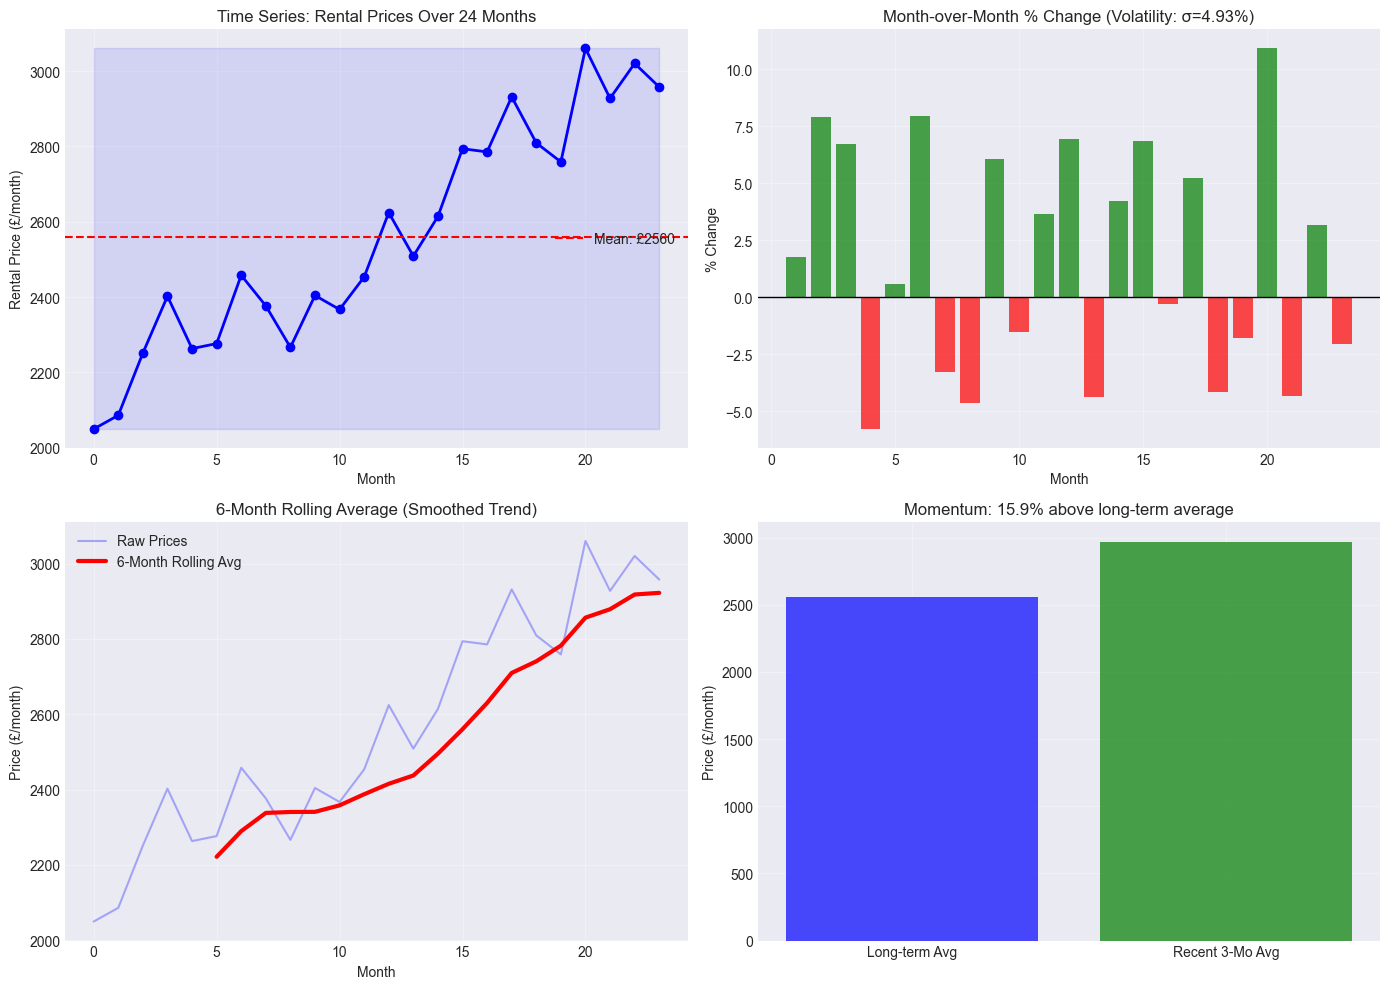

📈 Temporal Features Computed:
   Volatility (σ of % change): 4.93%
   Momentum: 15.9%
   6-mo growth: 7.8%


In [5]:
# Simulate time series data to show temporal features
np.random.seed(42)
months = np.arange(24)
base_price = 2000
trend = months * 50  # £50/month growth
seasonality = 100 * np.sin(2 * np.pi * months / 12)  # Seasonal pattern
noise = np.random.normal(0, 100, 24)
prices = base_price + trend + seasonality + noise

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Time series plot
axes[0, 0].plot(months, prices, 'b-', linewidth=2, marker='o')
axes[0, 0].axhline(prices.mean(), color='r', linestyle='--', label=f'Mean: £{prices.mean():.0f}')
axes[0, 0].fill_between(months, prices.min(), prices.max(), alpha=0.1, color='blue')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Rental Price (£/month)')
axes[0, 0].set_title('Time Series: Rental Prices Over 24 Months')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Month-over-month percent change
pct_change = np.diff(prices) / prices[:-1] * 100
axes[0, 1].bar(months[1:], pct_change, color=['green' if x > 0 else 'red' for x in pct_change], alpha=0.7)
axes[0, 1].axhline(0, color='black', linewidth=1)
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('% Change')
axes[0, 1].set_title(f'Month-over-Month % Change (Volatility: σ={pct_change.std():.2f}%)')
axes[0, 1].grid(True, alpha=0.3)

# 6-month rolling average
recent_6mo = pd.Series(prices).rolling(6).mean()
axes[1, 0].plot(months, prices, 'b-', alpha=0.3, label='Raw Prices')
axes[1, 0].plot(months, recent_6mo, 'r-', linewidth=3, label='6-Month Rolling Avg')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Price (£/month)')
axes[1, 0].set_title('6-Month Rolling Average (Smoothed Trend)')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Momentum calculation
long_avg = prices.mean()
recent_3mo = prices[-3:].mean()
momentum = (recent_3mo - long_avg) / long_avg * 100
axes[1, 1].bar(['Long-term Avg', 'Recent 3-Mo Avg'], [long_avg, recent_3mo], color=['blue', 'green'], alpha=0.7)
axes[1, 1].set_ylabel('Price (£/month)')
axes[1, 1].set_title(f'Momentum: {momentum:.1f}% above long-term average')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📈 Temporal Features Computed:")
print(f"   Volatility (σ of % change): {pct_change.std():.2f}%")
print(f"   Momentum: {momentum:.1f}%")
print(f"   6-mo growth: {((prices[-6:].mean() - prices[-12:-6].mean()) / prices[-12:-6].mean() * 100):.1f}%")

## 6. Complete Model Pipeline Summary

### The `train_model.py` Workflow:

1. **Load Data** → Read parquet files with district features
2. **Spatial Features** → Add K-NN neighbor averages (rent, growth, etc.)
3. **Temporal Features** → Add 6-mo growth, volatility, momentum
4. **Feature Engineering** → Create derived features (rental yield, supply ratio, price spread)
5. **Data Augmentation** → Generate synthetic data if samples < 20
6. **Train 3 Models** → Fit LightGBM quantile regressors for P10, P50, P90
7. **Evaluate** → Compute MAE, RMSE, MAPE, coverage metrics
8. **Explain** → Calculate SHAP feature importance
9. **Save** → Pickle the model artifact for deployment

### Key Components

| Component | Purpose | Key Technique |
|-----------|---------|---------------|
| **Quantile Regression** | Predict P10/P50/P90 | Asymmetric loss function |
| **Spatial Features** | Capture neighborhood effects | K-nearest neighbors averaging |
| **Temporal Features** | Model market dynamics | Growth rates, volatility, momentum |
| **Synthetic Data** | Augment small datasets | Realistic distributions with correlations |
| **LightGBM** | Gradient boosting | Optimized tree-based learning |
| **SHAP** | Explain predictions | Game-theoretic feature attribution |

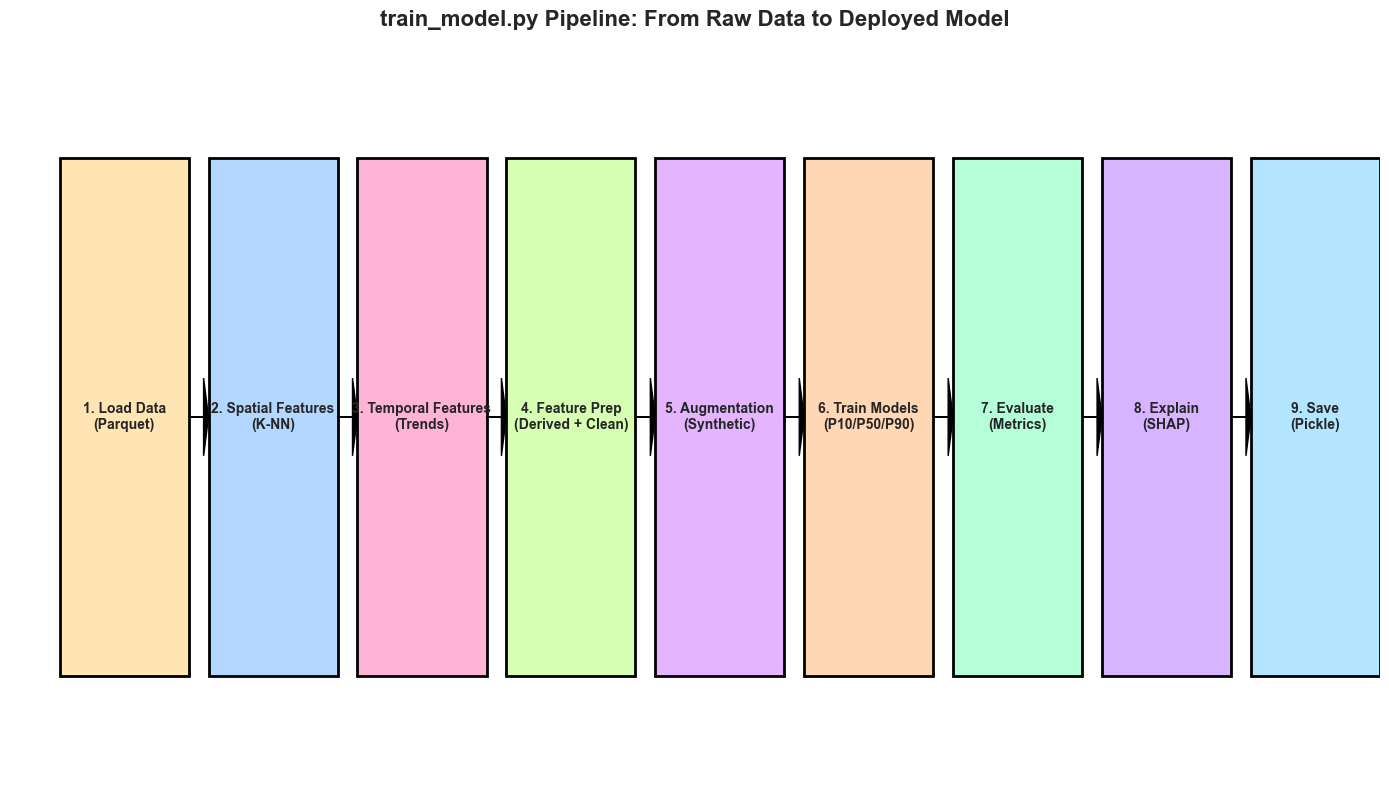

✅ This pipeline transforms raw district data into a production-ready quantile regression model


In [6]:
# Visualize the complete pipeline
fig, ax = plt.subplots(figsize=(14, 8))

stages = [
    "1. Load Data\n(Parquet)",
    "2. Spatial Features\n(K-NN)",
    "3. Temporal Features\n(Trends)",
    "4. Feature Prep\n(Derived + Clean)",
    "5. Augmentation\n(Synthetic)",
    "6. Train Models\n(P10/P50/P90)",
    "7. Evaluate\n(Metrics)",
    "8. Explain\n(SHAP)",
    "9. Save\n(Pickle)"
]

colors = ['#FFE5B4', '#B4D7FF', '#FFB4D7', '#D7FFB4', '#E5B4FF', '#FFD7B4', '#B4FFD7', '#D7B4FF', '#B4E5FF']

for i, (stage, color) in enumerate(zip(stages, colors)):
    rect = Rectangle((i * 1.5, 0), 1.3, 1, facecolor=color, edgecolor='black', linewidth=2)
    ax.add_patch(rect)
    ax.text((i * 1.5) + 0.65, 0.5, stage, ha='center', va='center', fontsize=10, fontweight='bold', wrap=True)
    
    if i < len(stages) - 1:
        ax.arrow((i * 1.5) + 1.3, 0.5, 0.15, 0, head_width=0.15, head_length=0.05, fc='black', ec='black')

ax.set_xlim(-0.5, len(stages) * 1.5 - 0.2)
ax.set_ylim(-0.2, 1.2)
ax.axis('off')
ax.set_title('train_model.py Pipeline: From Raw Data to Deployed Model', fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.show()

print("✅ This pipeline transforms raw district data into a production-ready quantile regression model")

## 7. Model Training and Hyperparameters

### LightGBM Configuration

```python
model = lgb.LGBMRegressor(
    objective="quantile",        # Use quantile loss
    alpha=q,                      # Quantile to predict (0.1, 0.5, or 0.9)
    n_estimators=150,             # Number of boosting rounds
    max_depth=5,                  # Maximum tree depth
    learning_rate=0.05,           # Step size shrinkage
    num_leaves=31,                # Max leaves per tree
    min_child_samples=5,          # Min samples in leaf
    subsample=0.8,                # Row sampling ratio
    colsample_bytree=0.8,         # Column sampling ratio
    reg_alpha=0.1,                # L1 regularization
    reg_lambda=0.1,               # L2 regularization
    random_state=42
)
```

### Why These Settings?

- **n_estimators=150**: Balance between accuracy and overfitting
- **learning_rate=0.05**: Conservative learning for stability
- **max_depth=5**: Prevents overly complex trees
- **subsample=0.8, colsample_bytree=0.8**: Regularization via randomness
- **reg_alpha, reg_lambda**: Penalize large coefficients

### Quantile-Specific Training

We train **3 separate models**:
- Model 1: `alpha=0.1` → P10 predictions
- Model 2: `alpha=0.5` → P50 predictions (median)
- Model 3: `alpha=0.9` → P90 predictions

Each model optimizes a different quantile loss function.

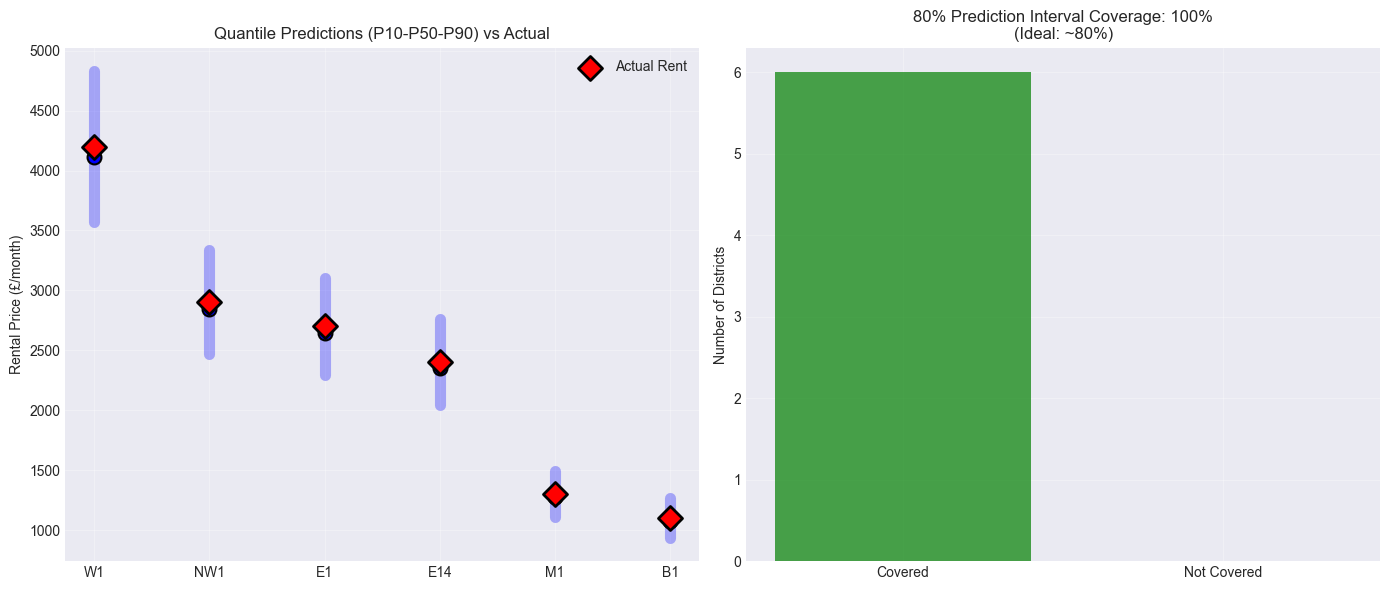

✅ Prediction Interval Analysis:
   Coverage: 100% of actual values fall within [P10, P90]
   Average interval width: £730
   Narrower intervals = more confidence, wider = more uncertainty


In [7]:
# Simulate prediction intervals to show quantile outputs
np.random.seed(42)
districts_sim = ['W1', 'NW1', 'E1', 'E14', 'M1', 'B1']
actual_rents = [4200, 2900, 2700, 2400, 1300, 1100]

# Simulate P10/P50/P90 predictions (model would generate these)
p10_preds = [r * 0.85 for r in actual_rents]
p50_preds = [r * 0.98 for r in actual_rents]  # Slight underestimate
p90_preds = [r * 1.15 for r in actual_rents]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Left plot: Prediction intervals
x_pos = np.arange(len(districts_sim))
axes[0].scatter(x_pos, actual_rents, s=150, c='red', marker='D', label='Actual Rent', zorder=3, edgecolors='black', linewidths=2)

for i in range(len(districts_sim)):
    # Vertical line from P10 to P90
    axes[0].plot([x_pos[i], x_pos[i]], [p10_preds[i], p90_preds[i]], 'b-', linewidth=8, alpha=0.3)
    # P50 marker
    axes[0].scatter(x_pos[i], p50_preds[i], s=100, c='blue', marker='o', zorder=2, edgecolors='black', linewidths=1.5)

axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(districts_sim)
axes[0].set_ylabel('Rental Price (£/month)')
axes[0].set_title('Quantile Predictions (P10-P50-P90) vs Actual')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Right plot: Coverage analysis
covered = [(actual_rents[i] >= p10_preds[i] and actual_rents[i] <= p90_preds[i]) for i in range(len(districts_sim))]
coverage_rate = np.mean(covered) * 100

axes[1].bar(['Covered', 'Not Covered'], [sum(covered), len(covered) - sum(covered)], 
           color=['green', 'red'], alpha=0.7)
axes[1].set_ylabel('Number of Districts')
axes[1].set_title(f'80% Prediction Interval Coverage: {coverage_rate:.0f}%\n(Ideal: ~80%)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✅ Prediction Interval Analysis:")
print(f"   Coverage: {coverage_rate:.0f}% of actual values fall within [P10, P90]")
print(f"   Average interval width: £{np.mean([p90_preds[i] - p10_preds[i] for i in range(len(districts_sim))]):.0f}")
print(f"   Narrower intervals = more confidence, wider = more uncertainty")

## 8. SHAP (SHapley Additive exPlanations) Theory

### What is SHAP?

SHAP values explain **how much each feature contributes** to a prediction, based on **game theory** (Shapley values).

**Shapley Value Formula:**

$$
\phi_i = \sum_{S \subseteq F \setminus \{i\}} \frac{|S|! \cdot (|F| - |S| - 1)!}{|F|!} \left[ f(S \cup \{i\}) - f(S) \right]
$$

where:
- $\phi_i$ = SHAP value for feature $i$
- $F$ = set of all features
- $S$ = subset of features
- $f(S)$ = model prediction using features in $S$

### Intuition

Imagine features are "players" in a game. SHAP values answer:
> **"What is the marginal contribution of feature $i$ across all possible coalitions?"**

### SHAP for Trees

For tree-based models (LightGBM, XGBoost), SHAP uses an efficient algorithm:
- Traverse decision paths in the trees
- Compute feature contributions along each path
- Aggregate across all trees

### Why SHAP?

✅ **Model-agnostic** (works for any ML model)  
✅ **Consistent** (guaranteed theoretical properties)  
✅ **Local explanations** (explains individual predictions)  
✅ **Global importance** (aggregate SHAP values across dataset)

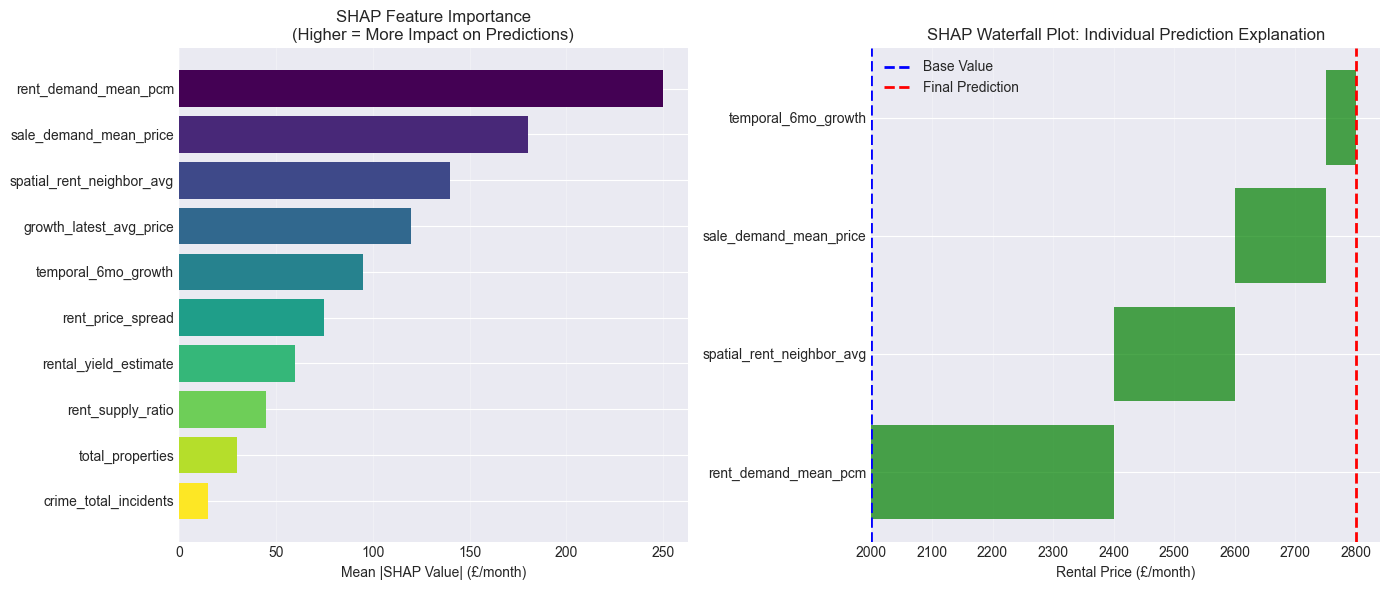

🔍 SHAP Insights:
   Top feature: rent_demand_mean_pcm (importance: 250)
   Waterfall shows: Base £2000 → Final £2800 (features add £800)


In [8]:
# Simulate SHAP feature importance
features = ['rent_demand_mean_pcm', 'sale_demand_mean_price', 'spatial_rent_neighbor_avg', 
            'growth_latest_avg_price', 'temporal_6mo_growth', 'rent_price_spread',
            'rental_yield_estimate', 'rent_supply_ratio', 'total_properties', 'crime_total_incidents']

# Simulated SHAP importance values (in reality, computed by SHAP algorithm)
shap_importances = [250, 180, 140, 120, 95, 75, 60, 45, 30, 15]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Bar chart of feature importance
colors_shap = plt.cm.viridis(np.linspace(0, 1, len(features)))
axes[0].barh(range(len(features)), shap_importances, color=colors_shap)
axes[0].set_yticks(range(len(features)))
axes[0].set_yticklabels(features)
axes[0].invert_yaxis()
axes[0].set_xlabel('Mean |SHAP Value| (£/month)')
axes[0].set_title('SHAP Feature Importance\n(Higher = More Impact on Predictions)')
axes[0].grid(True, alpha=0.3, axis='x')

# Waterfall plot for a single prediction
base_value = 2000  # Model's average prediction
prediction = 2800  # Final prediction for one district

contributions = {
    'Base Value': base_value,
    'rent_demand_mean_pcm': +400,
    'spatial_rent_neighbor_avg': +200,
    'sale_demand_mean_price': +150,
    'temporal_6mo_growth': +50,
}

cumulative = base_value
x_positions = [base_value]
colors_waterfall = []

for i, (feat, contrib) in enumerate(list(contributions.items())[1:]):
    if contrib > 0:
        colors_waterfall.append('green')
    else:
        colors_waterfall.append('red')
    cumulative += contrib
    x_positions.append(cumulative)

y_labels = list(contributions.keys())
axes[1].barh(range(len(y_labels) - 1), [contributions[k] for k in y_labels[1:]], 
            left=[x_positions[i] if contributions[y_labels[i+1]] > 0 else x_positions[i] + contributions[y_labels[i+1]] 
                  for i in range(len(y_labels) - 1)],
            color=colors_waterfall, alpha=0.7)

axes[1].axvline(base_value, color='blue', linestyle='--', linewidth=2, label='Base Value')
axes[1].axvline(prediction, color='red', linestyle='--', linewidth=2, label='Final Prediction')
axes[1].set_yticks(range(len(y_labels) - 1))
axes[1].set_yticklabels(y_labels[1:])
axes[1].set_xlabel('Rental Price (£/month)')
axes[1].set_title('SHAP Waterfall Plot: Individual Prediction Explanation')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print(f"🔍 SHAP Insights:")
print(f"   Top feature: {features[0]} (importance: {shap_importances[0]})")
print(f"   Waterfall shows: Base £{base_value} → Final £{prediction} (features add £{prediction - base_value})")

## 9. Conclusion and Key Takeaways

### What We've Learned

1. **Quantile Regression** provides prediction intervals (P10/P50/P90) instead of single points
2. **Spatial Features** capture neighborhood effects using K-nearest neighbors
3. **Temporal Features** model market dynamics (growth, volatility, momentum)
4. **Synthetic Data** augments small datasets while preserving realistic correlations
5. **LightGBM** efficiently trains gradient-boosted trees with quantile loss
6. **SHAP** explains predictions by attributing contributions to each feature

### Model Strengths

✅ Uncertainty quantification (critical for real estate decisions)  
✅ Incorporates spatial autocorrelation  
✅ Captures temporal trends  
✅ Handles small datasets via augmentation  
✅ Interpretable via SHAP  

### Model Limitations

⚠️ Relies on hardcoded district coordinates  
⚠️ Synthetic data may not capture all real-world complexity  
⚠️ Assumes stationary market conditions  
⚠️ No handling of macroeconomic shocks  

### Production Deployment

The trained model is saved as `rent_quantile_model.pkl` containing:
- 3 LightGBM models (P10, P50, P90)
- Feature names for input validation
- Training statistics for monitoring
- SHAP importance for debugging

### Next Steps

1. **Retrain** with more recent data
2. **A/B test** predictions against actual market outcomes
3. **Monitor** model drift over time
4. **Extend** with additional features (schools, transport, etc.)

---

**Thank you for exploring the JARZ-AI rental valuation model!**